In [1]:
wiki_path = './零之使魔_wiki.txt'
novel_path='./零之使魔.txt'
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'

include_novel=False
include_title=True
max_title_len=20
min_content_len=20
max_content_len=100
chunk_overlap=50

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# faiss_cache_dir=output_dir+'faiss_cache'
# if not os.path.exists(faiss_cache_dir):
#     os.makedirs(faiss_cache_dir)

# 读取wiki txt，分块

successfully read novel text from  ./零之使魔.txt
successfully read wiki text from  ./零之使魔_wiki.txt


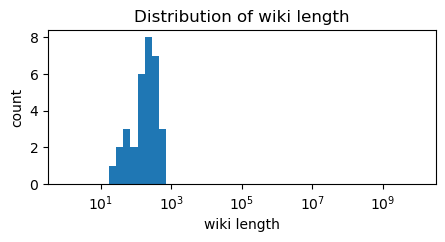

Number of wikis:  32


In [2]:
import re

with open(novel_path,'r',encoding='utf-8') as f:
    novel_text=f.read()
print('successfully read novel text from ', novel_path)

re_chapter_title=re.compile(r"^(.{1,8}章|.{1,8}篇|.{1,8}集|.{1,8}卷|后记|序)\s", flags=re.MULTILINE)
chapters = re.split(re_chapter_title, novel_text)[1:]
chapters = [chapters[i]+' '+chapters[i + 1] for i in range(0, len(chapters), 2) if len(chapters[i + 1]) > min_content_len]
chapter_titles=[chapter.split('\n')[0].strip()[:max_title_len] for chapter in chapters]
chapters=[chapter.split('\n',1)[1] for chapter in chapters]
    
with open(wiki_path,'r',encoding='utf-8') as f:
    wiki_text=f.read()
print('successfully read wiki text from ', wiki_path)

re_wiki_title=re.compile(r"^(【词条】)\s", flags=re.MULTILINE)
wikis=re.split(re_wiki_title,wiki_text)[1:]
wikis=[wikis[i]+' '+wikis[i+1] for i in range(0,len(wikis),2) if len(wikis[i+1])>min_content_len]
wiki_titles=[wiki.split('\n')[0].strip().replace('【词条】','')[:max_title_len] for wiki in wikis]
wikis=[wiki.split('\n',1)[1] for wiki in wikis]


import matplotlib.pyplot as plt
import numpy as np
if include_novel:
    plt.figure(figsize=(5, 2))
    plt.hist([len(chapter) for chapter in chapters], bins=np.logspace(0, 10, 50))
    plt.xscale('log');plt.xlabel('chapter length');plt.ylabel('count');plt.title('Distribution of chapter length');plt.show()
    print('Number of chapters: ', len(chapters))

plt.figure(figsize=(5, 2))
plt.hist([len(wiki) for wiki in wikis], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('wiki length');plt.ylabel('count');plt.title('Distribution of wiki length');plt.show()
print('Number of wikis: ', len(wikis))


Number of documents:  120


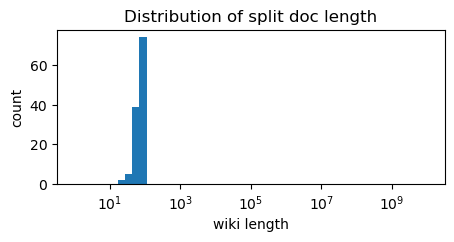

Number of docs:  120


In [3]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(chunk_size=max_content_len,chunk_overlap=chunk_overlap)

documents=[]
documents+=[Document(page_content=wiki,metadata={'title':title,'type':'wiki'}) for wiki,title in zip(wikis,wiki_titles)]
if include_novel:
    documents+=[Document(page_content=chapter,metadata={'title':title,'type':'novel'}) for chapter,title in zip(chapters,chapter_titles)]
documents=text_splitter.split_documents(documents)
for doc in documents:
    if include_title:
        doc.page_content=doc.metadata['title']+'\n'+doc.page_content
    doc.page_content=doc.page_content.replace('\n',' ').strip()
documents=[doc for doc in documents if len(doc.page_content)>min_content_len]

print('Number of documents: ', len(documents))

import random
random.sample(documents,5)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 2))
plt.hist([len(doc.page_content) for doc in documents], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('wiki length');plt.ylabel('count');plt.title('Distribution of split doc length');plt.show()
print('Number of docs: ', len(documents))

# 建立FAISS索引

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
import sentence_transformers
from langchain.vectorstores import FAISS

embeddings=HuggingFaceEmbeddings(model_name_or_path='bert-base-chinese')

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
import sentence_transformers
from langchain.vectorstores import FAISS

embeddings = HuggingFaceEmbeddings(model_name=r'D:\ml\text2vec-large-chinese')
embeddings.client=sentence_transformers.SentenceTransformer(embeddings.model_name,device="cuda")

: 

In [14]:
# WARNING VERY SLOW
from tqdm.auto import tqdm
import os


# save every 50 doc in one folder
# vector_stores=[]
# for i in tqdm(range(0,len(documents),50)):
#     vector_store_dir=os.path.join(faiss_cache_dir,'{0:06d}'.format(i))
#     if not os.path.exists(vector_store_dir+'/index.faiss'):
#         print('building vector store for documents ',i,' to ',i+100)
#         vector_store = FAISS.from_documents(documents[i:i+100], embeddings)
#         os.makedirs(vector_store_dir)
#         vector_store.save_local(vector_store_dir)
#         print('saved vector store to ', vector_store_dir)
#     else:
#         vector_store=FAISS.load_local(vector_store_dir, embeddings)
#         print('loaded vector store from ', vector_store_dir)
#     vector_stores.append(vector_store)
# vector_store=vector_stores[0]
# for i in range(1,len(vector_stores)):
#     vector_store.merge_from(vector_stores[i])
# vector_store.save_local(faiss_path)
# print('saved vector store to ', faiss_path)
# del vector_stores

if os.path.exists(faiss_path+'/index.faiss'):
    vector_store=FAISS.load_local(faiss_path, embeddings)
    print('loaded vector store from ', faiss_path)
else:
    vector_store = FAISS.from_documents(documents, embeddings)
    vector_store.save_local(faiss_path)
    print('saved vector store to ', faiss_path)

loaded vector store from  ./output_zero/faiss_index


In [12]:
queries=[
    '路易斯',
    '才人取出了武器',
    '才人大战约瑟夫',
    '路易斯在吵架',
]

for query in queries:
    print('query: ',query)
    results=vector_store.similarity_search(query, k=5)
    print('results: ')
    for doc in results:
        print(repr(doc.page_content))

query:  路易斯
results: 
'露易丝 露易丝·法兰西斯·露·布朗·杜·拉·瓦利埃尔 本作女主角，作品中一般称为露易丝，有着夹杂金色的粉红长卷发、茶褐色的眼瞳（动画为桃红色）。'
'平贺才人 已与露易斯同居中。同时被书中许多女性角色爱慕著。喜欢露易丝。'
'露易丝 本作女主角，作品中一般称为露易丝，有着夹杂金色的粉红长卷发、茶褐色的眼瞳（动画为桃红色）。 在托里斯汀东北拥有领土的名门拉·瓦利埃尔公爵家的三女儿、托里斯汀魔法学院的二年级学生。'
'托里斯汀 是一个位于哈尔凯尼亚西北部，历史悠久的小王国，故事女主角露易丝的祖国，大部分的故事都发生于此。 （位置大致相当于欧洲的低地三国。）首都为托里斯塔尼亚（Tristania）'
'基修·杜·格拉蒙 露易丝的同学。父亲则是托里斯汀的元帅。尽管爱上了蒙莫朗西，却是个花花公子，总是不能决定自己喜欢谁。'
query:  才人取出了武器
results: 
'德鲁弗林加 在小说第十六集中为了救才人，刀身过量吸收杀手元素兄弟的魔法攻击而被毁，不过却及时把精神力转移至才人的武士刀上，在小说十九集中才人与精灵亚利对决中再度觉醒。'
'手枪 被露易丝以“爆炸”魔法成功阻止。后来归才人所有，正式名称是SIG P226手枪， 使用9x19mm子弹。才人在与约瑟夫的战斗中丢弃。'
'平贺才人 武器是露易丝替他买的一把剑，原本只是因为会说话好玩而买下，但后来才知那把剑是拥有知性的“智慧之剑”（Derflinger），那剑在过去6,000年都是由Gandalfr所使用的。'
'德鲁弗林加 才人平时用的长剑，有自我意识的智慧之剑。因为表面破烂不堪，露易丝以相当低廉的价格就买下了，并且送给才人当配剑。 被才人称作“迪尔夫”[小说中翻译为德鲁]，自己则以“伙伴”称呼才人。很喜欢说话。'
'长枪 而存于罗马尼亚大圣堂底下的“工艺品”即为长枪，就是才人所用的“虎式坦克”、“AK突击步枪”、“自动手枪”之类的发射型武器。 但由密探带回的武器并非只有发射型武器，就连日本武士的日本刀也有。'
query:  才人大战约瑟夫
results: 
'手枪 被露易丝以“爆炸”魔法成功阻止。后来归才人所有，正式名称是SIG P226手枪， 使用9x19mm子弹。才人在与约瑟夫的战斗中丢弃。'
'谢斯塔 学院里服侍贵族学生和一切杂役的女仆，在故事刚登场时与

In [13]:
random_context=random.sample(chapters,1)[0]
random_context=random_context[random.randint(0,len(random_context)-500):][:500]
print('random document:\n',random_context)
results=vector_store.similarity_search(random_context, k=5)
print('results: ')
for doc in results:
    print(repr(doc.page_content))
    

random document:
 酒。
    基姆利以开玩笑的口吻说完后，少年们纷纷聚拢到露易丝和蒂法妮娅的身边，以醉汉的模样完成了三遍「万岁」的欢呼。
    「圣战万岁！罗马尼亚万岁！艾克蕾亚的圣女万岁！」
    接着互相对着脸一句「都在张口乱叫些什么啊」后，互相大笑了起来。露易丝以冷冷的视线环绕着看了一圈醉酒的少年，发现里面没有才人的身影。
    「才人呢？」
    「啊，那个家伙不在哦，说什么有要交给塔巴萨的东西，早就不见了。」
    马里科尔奴答道。
    「塔巴萨？」
    露易丝的肩膀忽然动了一下。
    果然那家伙对那娇小的塔巴萨……也伸出了魔爪了啊！？
    在露易丝心中一直故意没有去想的疑问在不断的膨大，一种对雪丝塔、安莉埃塔或者蒂法妮娅时完全不同的醋意开始包裹住她。
    对充满女性魅力的他们才人有所反应也是没办法的事情，虽然很上火但是也是情理之中。
    但是，塔巴萨却不一样。比自己还小，胸部也不是完全没有吗？如果才人是一般的趣味，自己肯定是输了的。
    但是反过来如果才人不是有那方面趣味的话……
    露易丝从那个蓝头发的少女的身上感到了足以能够抵消以上的那些缺点的
results: 
'露易丝 性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。 动画第三期中为救出塔巴萨而放弃贵族身份，但被公主赏识，成为王位继承人。喜欢平贺才人。'
'谢斯塔 谢斯塔的本性善良温和，但只要牵扯到与才人恋爱有关的事物，就会展现出平时没有的积极及勇气，甚至可以称之为激烈的性格。'
'露易丝 实际上是少见的“虚无”系统的魔法师（虚无使用者），只要情绪起伏大就能蓄积大量魔力。 性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。'
'安丽埃塔 在小说第四集绑架事件落幕后，安丽埃塔对于数次拯救她和国家危机的才人逐渐倾心，在第4部动画里曾用魔法镜子到才人密室而跟才人接吻，也让露易丝和谢丝坦感受到严重的危机威胁。'
'塔巴萨 塔巴萨是她的别名（是她妈妈送给她的玩偶名字），其真名为夏洛特·埃里努·奥尔良。她妈妈因为要保护塔巴萨而中了水魔法之毒而变得疯癫（后来约瑟夫战死后得到解药恢复心智），所以塔巴萨一直都封闭自己的话语和表情'
